# 1. Install Dependencies and Setup

In [1]:
pip list

Package                      Version
---------------------------- -----------
anyio                        3.7.1
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
async-lru                    2.0.4
attrs                        23.1.0
Babel                        2.12.1
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
certifi                      2023.7.22
cffi                         1.15.1
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.2
dacite                       1.8.1
debugpy                      1.6.6
decorator                    5.1.1
defusedxml                   0.7.1
exceptiongroup               1.1.1
executing                    1.2.0
fastjsonschema               2.18.0
flatbuffers                  23.5.26
fqdn                         1.5.1
h11                          0.14.

You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [57]:
data_dir = r'E:\Project\GeorgeClassification\data\raw' 

In [58]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [59]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

NotADirectoryError: [WinError 267] The directory name is invalid: 'E:\\Project\\GeorgeClassification\\data\\raw\\.gitkeep'

# 3. Load Data

In [60]:
import numpy as np
from matplotlib import pyplot as plt

In [61]:
data = tf.keras.utils.image_dataset_from_directory(r'E:\Project\GeorgeClassification\data\raw')

Found 5600 files belonging to 2 classes.


In [62]:
data_iterator = data.as_numpy_iterator()

In [63]:
batch = data_iterator.next()

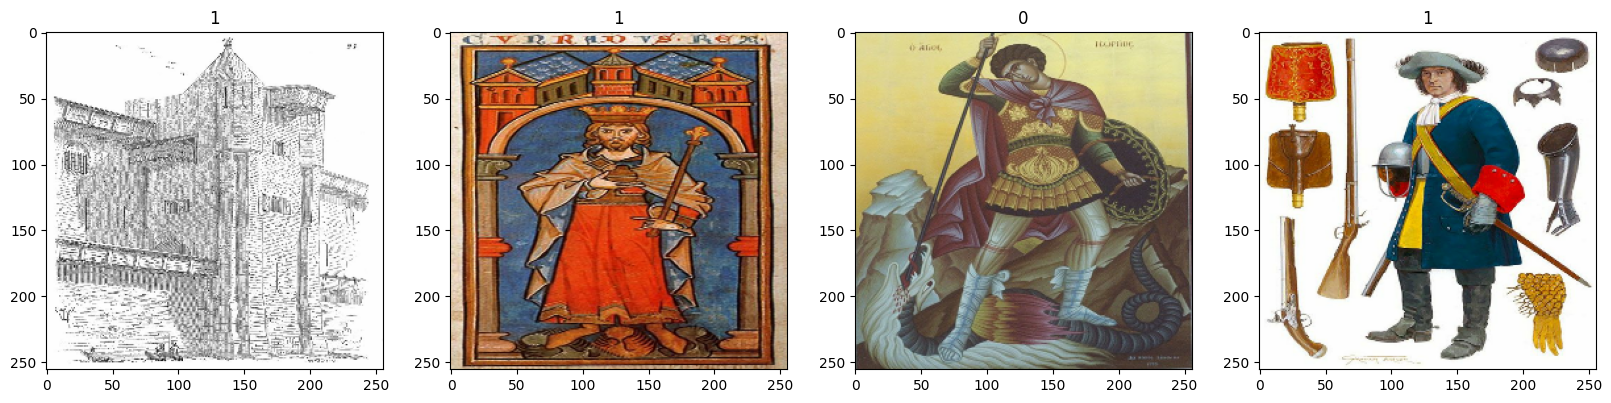

In [64]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [2]:
classes = {
    "george" : 0,
    "non George": 1
}

In [3]:
import json
with open(r"E:\Project\GeorgeClassification\server\artifacts\class_dictionary.json", "w") as f:
    f.write(json.dumps(classes))

# 4. Scale Data

In [66]:
data = data.map(lambda x,y: (x/255, y))

In [67]:
data.as_numpy_iterator().next()

(array([[[[0.4750919 , 0.40554535, 0.36372548],
          [0.71130514, 0.6524663 , 0.581924  ],
          [0.9025582 , 0.85612744, 0.74836093],
          ...,
          [0.5278952 , 0.4926011 , 0.42856923],
          [0.514614  , 0.47931984, 0.4204963 ],
          [0.7860294 , 0.7507353 , 0.69191176]],
 
         [[0.36473653, 0.30277267, 0.24434742],
          [0.64856005, 0.5956035 , 0.51525736],
          [0.83851105, 0.79666054, 0.6790901 ],
          ...,
          [0.4689951 , 0.42193627, 0.36443016],
          [0.40079656, 0.35373774, 0.29883578],
          [0.6963848 , 0.64932597, 0.594424  ]],
 
         [[0.25450367, 0.20626532, 0.12326899],
          [0.5893842 , 0.5478094 , 0.43843442],
          [0.760095  , 0.7299939 , 0.5882353 ],
          ...,
          [0.48400736, 0.43170956, 0.37942708],
          [0.32449448, 0.26959252, 0.21861213],
          [0.50693935, 0.45203736, 0.40105698]],
 
         ...,
 
         [[0.8971201 , 0.9022212 , 0.9290135 ],
          [0.34987

# 5. Split Data

In [68]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [69]:
train_size

122

In [70]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [71]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [73]:
model = Sequential()

In [74]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [77]:
logdir='logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [79]:
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
122/122 [==============================] - 26s 208ms/step - loss: 0.6687 - accuracy: 0.6437 - val_loss: 0.6188 - val_accuracy: 0.6732
Epoch 2/30
122/122 [==============================] - 15s 116ms/step - loss: 0.6016 - accuracy: 0.6849 - val_loss: 0.6264 - val_accuracy: 0.6554
Epoch 3/30
122/122 [==============================] - 15s 123ms/step - loss: 0.5847 - accuracy: 0.6993 - val_loss: 0.5955 - val_accuracy: 0.7063
Epoch 4/30
122/122 [==============================] - 15s 121ms/step - loss: 0.4978 - accuracy: 0.7626 - val_loss: 0.5764 - val_accuracy: 0.7259
Epoch 5/30
122/122 [==============================] - 15s 122ms/step - loss: 0.3883 - accuracy: 0.8222 - val_loss: 0.5548 - val_accuracy: 0.7670
Epoch 6/30
122/122 [==============================] - 15s 122ms/step - loss: 0.3008 - accuracy: 0.8742 - val_loss: 0.6008 - val_accuracy: 0.7446
Epoch 7/30
122/122 [==============================] - 15s 122ms/step - loss: 0.2141 - accuracy: 0.9162 - val_loss: 0.7749 - val_ac

# 8. Plot Performance

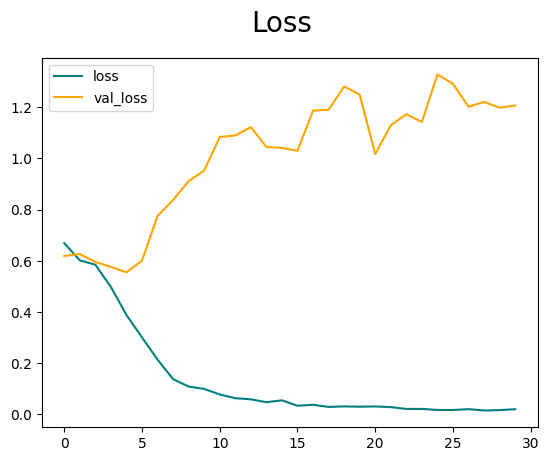

In [80]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

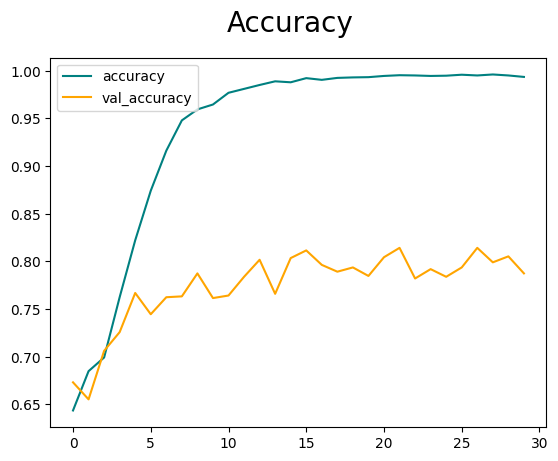

In [81]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [82]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [83]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [84]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 28ms/step


In [85]:
print(f"{pre.result()}, {re.result()}, {acc.result()}")

0.8225806355476379, 0.730659008026123, 0.7261029481887817


# 10. Test

In [48]:
import cv2

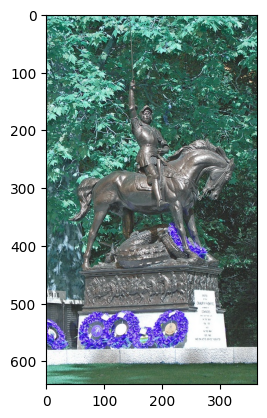

In [50]:
img = cv2.imread(r'E:\Project\GeorgeClassification\data\processed\george\0a5f7b5996063605dd05887ef4d31855.jpg')
plt.imshow(img)
plt.show()

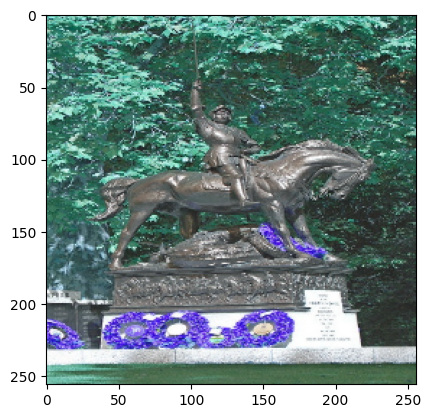

In [51]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [52]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 1s 514ms/step


In [53]:
yhat

array([[1.]], dtype=float32)

In [55]:
if yhat > 0.5: 
    print(f'Predicted class is not george')
else:
    print(f'Predicted class is george')

Predicted class is not george


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)